In [1]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["image.cmap"] = "magma"

from tqdm.notebook import tqdm

import warnings

import os
import numpy as np

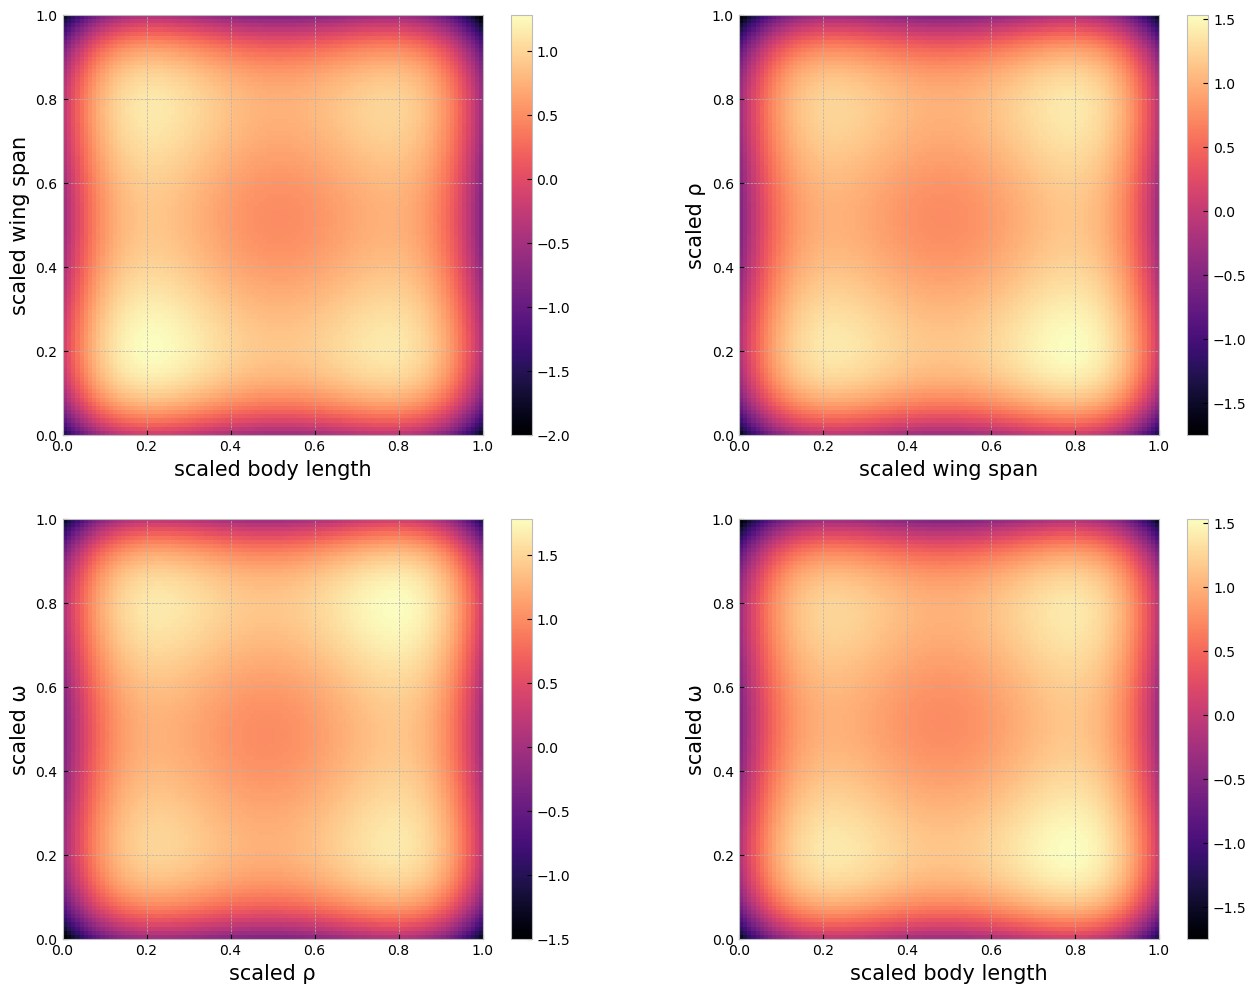

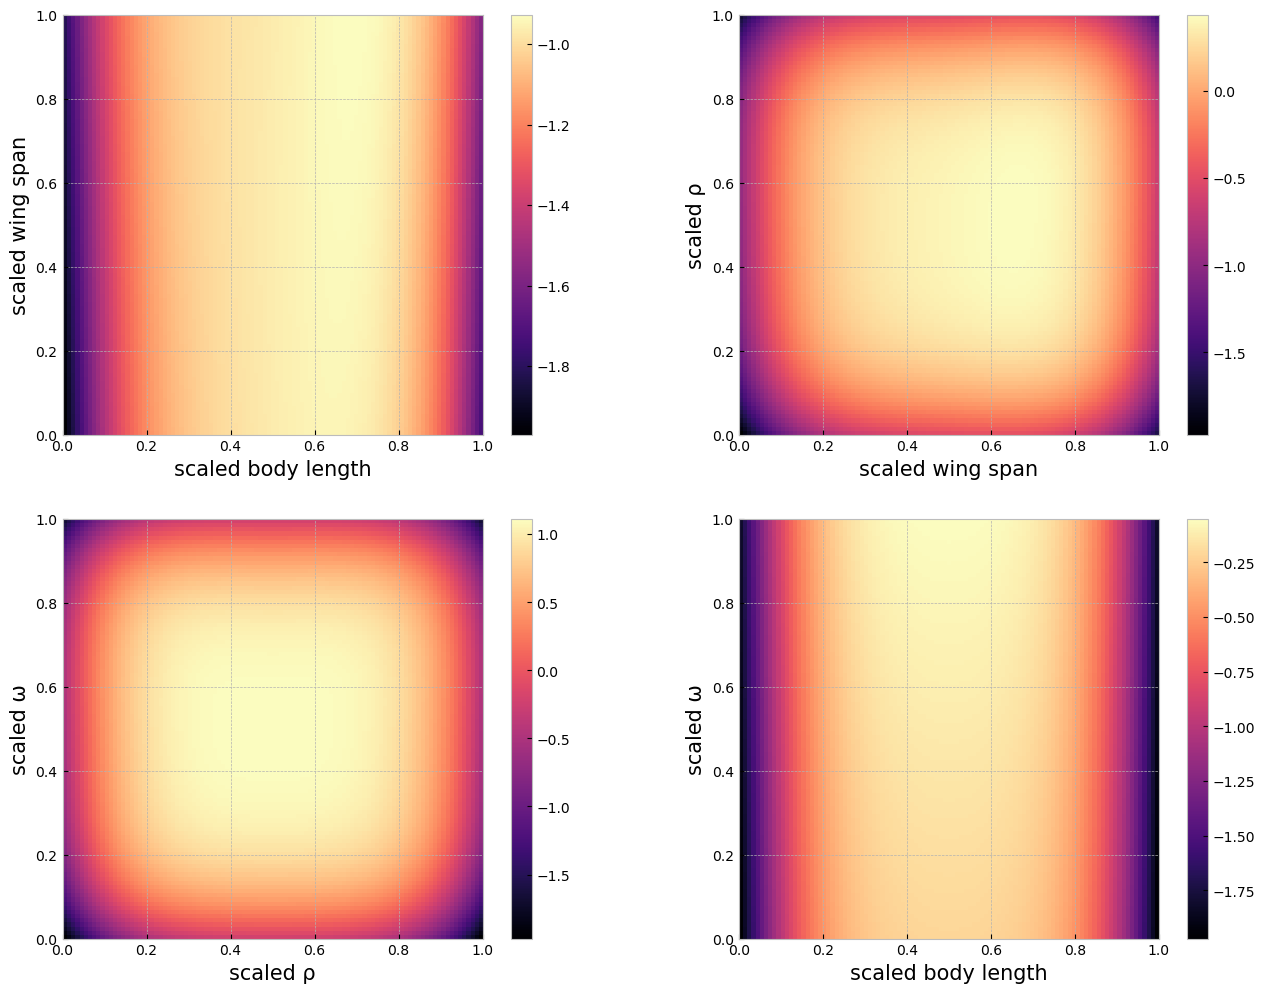

In [2]:
labels = ["scaled body length", "scaled wing span", "scaled ρ", "scaled ω"]


def visualize_objective(f):
    dimensions_to_plot = [(0, 1), (1, 2), (2, 3), (0, 3)]

    grid_x = torch.linspace(0, 1, 101)
    grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
    grid_x1 = grid_x1.flatten()
    grid_x2 = grid_x2.flatten()

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    for ax_ind, (i, j) in enumerate(dimensions_to_plot):
        tmp_ax = ax[ax_ind // 2][ax_ind % 2]

        xs = torch.zeros(101 ** 2, 4)
        xs[:, i] = grid_x1
        xs[:, j] = grid_x2

        c = tmp_ax.imshow(
            f(xs).reshape(101, 101),
            origin="lower",
            extent=[0, 1, 0, 1],
        )
        plt.colorbar(c, ax=tmp_ax)

        tmp_ax.set_xlabel(labels[i], fontsize=15)
        tmp_ax.set_ylabel(labels[j], fontsize=15)

    plt.show()


def flight_utility(X):
    X_copy = X.detach().clone()
    X_copy[:, [2, 3]] = 1 - X_copy[:, [2, 3]]
    X_copy = X_copy * 10 - 5

    return -0.005 * (X_copy ** 4 - 16 * X_copy ** 2 + 5 * X_copy).sum(dim=-1) + 3


def flight_cost(X):
    X = X * 20 - 10

    part1 = (X[..., 0] - 1) ** 2

    i = X.new(range(2, 5))
    part2 = torch.sum(i * (2.0 * X[..., 1:] ** 2 - X[..., :-1]) ** 2, dim=-1)

    return -(part1 + part2) / 100_000 + 2


visualize_objective(flight_utility)
visualize_objective(flight_cost)

In [3]:
bounds = torch.tensor([[0.0] * 4, [1.0] * 4])

In [4]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=4)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [5]:
num_queries = 50
num_repeats = 10

In [6]:
strategy = "cei"  # "cei" or "ei"
strategy = strategy.upper()

# -2 is the default value when no feasible has been found
default_value = -2
feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 4)
    train_utility = flight_utility(train_x)
    train_cost = flight_cost(train_x)

    for i in tqdm(range(num_queries)):
        feasible_flag = (train_cost <= 0).any()

        if feasible_flag:
            feasible_incumbents[trial, i] = train_utility[train_cost <= 0].max()

        utility_model, utility_likelihood = fit_gp_model(train_x, train_utility)
        cost_model, cost_likelihood = fit_gp_model(train_x, train_cost)

        if feasible_flag:
            best_f = train_utility[train_cost <= 0].max()
        else:
            best_f = torch.tensor(default_value)

        if strategy == "EI":
            policy = botorch.acquisition.analytic.ExpectedImprovement(
                model=utility_model,
                best_f=train_utility.max(),
            )

        if strategy == "CEI":
            policy = botorch.acquisition.analytic.ConstrainedExpectedImprovement(
                model=botorch.models.model_list_gp_regression.ModelListGP(
                    utility_model, cost_model
                ),
                best_f=best_f,
                objective_index=0,
                constraints={1: [None, 0]},
            )
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=100,
                raw_samples=500,
            )

        next_utility = flight_utility(next_x)
        next_cost = flight_cost(next_x)

        train_x = torch.cat([train_x, next_x])
        train_utility = torch.cat([train_utility, next_utility])
        train_cost = torch.cat([train_cost, next_cost])

trial 0


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


trial 1


  0%|          | 0/50 [00:00<?, ?it/s]

trial 2


  0%|          | 0/50 [00:00<?, ?it/s]

trial 3


  0%|          | 0/50 [00:00<?, ?it/s]

trial 4


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


trial 5


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


trial 6


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


trial 7


  0%|          | 0/50 [00:00<?, ?it/s]

trial 8


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


trial 9


  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
torch.save(feasible_incumbents, f"./airplane_design/{strategy}.pth")

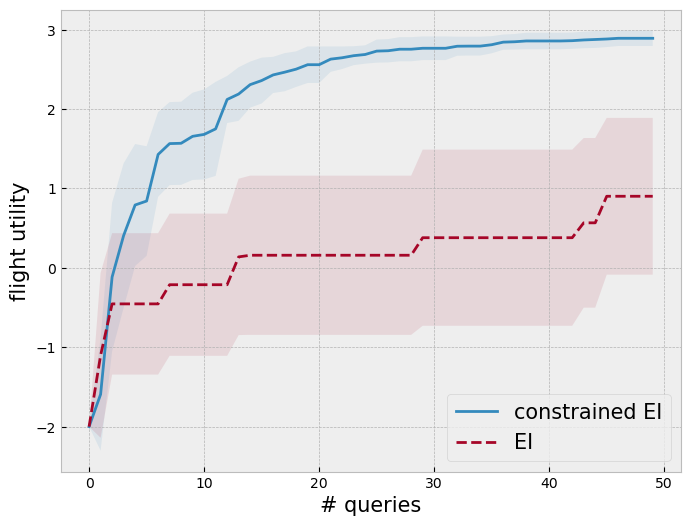

In [8]:
num_repeats = 10


def show_agg_progress(path, name, linestyle="solid"):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_repeats)

    incumbents = torch.load(path)
    avg_incumbent = incumbents.mean(axis=0)
    ci_incumbent = ci(incumbents)

    plt.plot(avg_incumbent, linestyle=linestyle, label=name)
    plt.fill_between(
        np.arange(num_queries),
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.1,
    )


plt.figure(figsize=(8, 6))

show_agg_progress("./airplane_design/CEI.pth", "constrained EI",)
show_agg_progress("./airplane_design/EI.pth", "EI", linestyle="--")

plt.xlabel("# queries", fontsize=15)
plt.ylabel("flight utility", fontsize=15)

plt.legend(fontsize=15);